## Breast Cancer Prediction using classification models

In [1]:
#importing Libraries

import numpy as np                # For mathematical calculations
import pandas as pd

import sklearn as sp              # For plotting graphs
import matplotlib.pyplot as plt   # For data visualization
import seaborn as sns             # For data visualization

from sklearn import preprocessing                 #feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn import decomposition       
from sklearn.decomposition import PCA 

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal #PDF


%matplotlib inline

In [2]:
# 1. Data Collection
df = pd.read_csv('train_main.csv')

    #remove unnamed dummy collumn
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [3]:
# Dropping data with duplicate information
df = df.drop(['id','radius_se', 'texture_se','perimeter_se','area_se','smoothness_se','compactness_se','concavity_se','concave points_se','symmetry_se','fractal_dimension_se','radius_worst','texture_worst','perimeter_worst','area_worst','smoothness_worst','compactness_worst','concavity_worst','concave points_worst','symmetry_worst','fractal_dimension_worst'], axis = 1)

In [4]:
#df.rename(columns=lambda x: x.split(':')[0], inplace=True)
df.columns = ['diagnosis','radius','texture','perimeter','area','smoothness','compactness','concavity','concave_points','symmetry','fractal_dimension']

#### DATASET DESCRIPTION

In [5]:
df.head()

,diagnosis,radius,texture,perimeter,area,smoothness,compactness,concavity,concave_points,symmetry,fractal_dimension
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


#### D.	Exploratory Data Analysis

In [6]:
    #Viewing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   diagnosis          569 non-null    object 
 1   radius             569 non-null    float64
 2   texture            569 non-null    float64
 3   perimeter          569 non-null    float64
 4   area               569 non-null    float64
 5   smoothness         569 non-null    float64
 6   compactness        569 non-null    float64
 7   concavity          569 non-null    float64
 8   concave_points     569 non-null    float64
 9   symmetry           569 non-null    float64
 10  fractal_dimension  569 non-null    float64
dtypes: float64(10), object(1)
memory usage: 49.0+ KB


In [7]:
df.isnull().sum()

diagnosis            0
radius               0
texture              0
perimeter            0
area                 0
smoothness           0
compactness          0
concavity            0
concave_points       0
symmetry             0
fractal_dimension    0
dtype: int64

As seen all Data entries are consistent.

In [8]:
    #Viewing data
df.describe()

,radius,texture,perimeter,area,smoothness,compactness,concavity,concave_points,symmetry,fractal_dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440


#### Target Value Analysis

In [9]:
# Univariate Analysis
df['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [10]:
# Normalizing Diagnosis: scaling values from 0 to 1 instead of number
df['diagnosis'].value_counts(normalize=True)

B    0.627417
M    0.372583
Name: diagnosis, dtype: float64

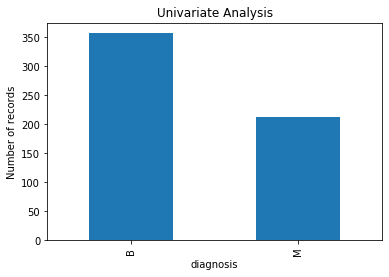

In [11]:
plt.xlabel('diagnosis')
plt.ylabel('Number of records')
plt.title('Univariate Analysis')
df['diagnosis'].value_counts().plot.bar()
plt.show()

# Analysis for independent variables

In [12]:
def scale(x):
    scaler = preprocessing.MinMaxScaler()
    df=pd.DataFrame(scaler.fit_transform(x), columns=x.columns)
    return df

In [13]:
visual=pd.DataFrame(df)
label=pd.DataFrame(df['diagnosis'])
visual=visual.drop(['diagnosis'], axis=1)

In [14]:
visual=scale(visual)

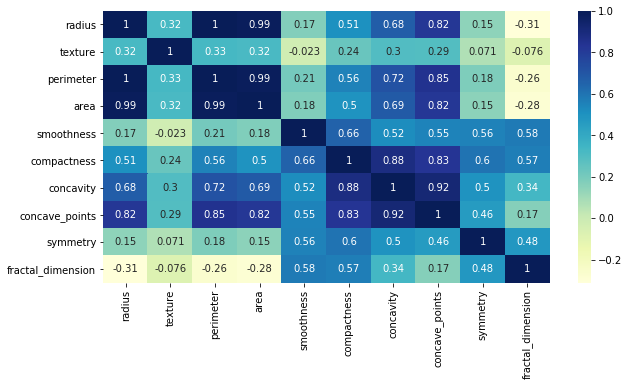

In [15]:
f, axes = plt.subplots(figsize=(10,5))
v=visual.corr()
sns.heatmap(v, annot=True, cmap="YlGnBu")

In [16]:
#features ranking using selectkbest
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(visual,label)

dfscores = pd.DataFrame(fit.scores_) #generate feature score
dfcolumns = pd.DataFrame(visual.columns)  #extract feature name

#combine rank and feature name
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #Headings

print(featureScores.nlargest(8,'Score'))  #print score

            Specs      Score
7  concave_points  52.405743
6       concavity  46.186395
3            area  29.328594
2       perimeter  26.528902
0          radius  24.897293
5     compactness  20.353176
1         texture   6.394071
8        symmetry   3.133130


In [17]:
sns.set(style="whitegrid")

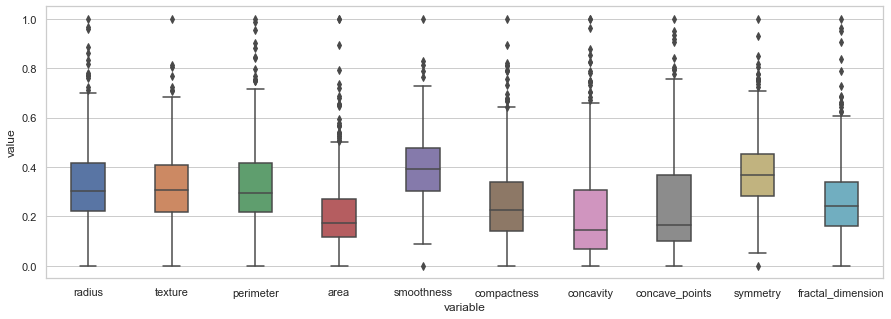

In [18]:
f, axes = plt.subplots(figsize=(15,5))
sns.boxplot(x="variable", y="value",width=0.4,data=pd.melt(visual))

In [ ]:
f, axes = plt.subplots(1, 10,figsize=(20,5))
i=0
for col in visual:
    sns.distplot(visual[col],ax=axes[i],label=col)
    i=i+1
    f.tight_layout(pad=1)
plt.show()

In [ ]:
# f, axes = plt.subplots(2, 2,figsize=(10,5))

hist = df[df.diagnosis == 'M']
sns.distplot(hist['radius'], label='M')
hist = df[df.diagnosis == 'B']
sns.distplot(hist['radius'], label='B')
# Plot formatting
plt.legend(prop={'size': 12})
plt.title('xxx')
plt.xlabel('radius')
plt.ylabel('diagnosis')

sns.catplot(x='diagnosis',y='radius',data=df,)

In [ ]:
pca1 = decomposition.PCA(n_components = 2)
pca1.fit(visual)
x_transformed = pca1.transform(visual)
x_transformed_df = pd.DataFrame(x_transformed)

PCA_dataset = pd.concat([x_transformed_df,label], axis = 1)
PCA_dataset.columns=['PCA_Feature_1', 'PCA_Feature_2', 'Label']

sns.lmplot(x ='PCA_Feature_1', y='PCA_Feature_2', hue ='Label', data = PCA_dataset, fit_reg=False )
plt.show()

## Data Preprocessing

In [ ]:
# replace B=0, M=1
label.replace('M', 1, inplace=True)
label.replace('B', 0, inplace=True)

## Modelling

Anomaly Detection

In [ ]:
#splitting dataset
x_train,x_test,y_train,y_test=train_test_split(visual,label,test_size=0.2, random_state=42)

In [ ]:
def estimateGaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma
    
def multivariateGaussian(dataset,mu,sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    return p.pdf(dataset)

def selectThreshold(probs,gt):
    best_epsilon = 0
    best_f1 = 0
    f = 0
    max=probs.max()
    min=probs.min()
    stepsize = (max-min) / 1000;
    
    for epsilon in np.arange(min,max,stepsize):
        predictions = (probs < epsilon) 
        f = f1_score(gt, predictions,average='micro')
        if f > best_f1:
            best_f1 = f
            best_epsilon = epsilon
    
    return best_f1, best_epsilon

In [ ]:
#Mean and standard deviation for anomaly
mu, sigma = estimateGaussian(x_train)
p = multivariateGaussian(x_train,mu,sigma)

In [ ]:
#selecting optimal value of epsilon using cross validation
p_test = multivariateGaussian(x_test,mu,sigma)
fscore, ep = selectThreshold(p_test,y_test)
print(fscore, ep)

In [ ]:
#selecting outlier datapoints 
outliers = (p < ep)

In [ ]:
fig, ax = plt.subplots()
ax.plot(x_train['concave_points'], y_train, 'x', color='red',label='True')
ax.plot(x_train['concave_points'], (outliers+0.2)*0.9, '>', color='blue',label='Predicted')
leg = ax.legend()